<a href="https://colab.research.google.com/github/coding-ss/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=63.87557484087011, mobile=True), User(purchased=False, time_on_site=265.64284173007064, mobile=True), User(purchased=False, time_on_site=157.01396461892273, mobile=False), User(purchased=False, time_on_site=178.2909634242509, mobile=True), User(purchased=False, time_on_site=287.09445423255255, mobile=True), User(purchased=False, time_on_site=512.6521183143507, mobile=False), User(purchased=False, time_on_site=477.72148268739596, mobile=False), User(purchased=False, time_on_site=146.94726361367597, mobile=True), User(purchased=False, time_on_site=434.0161358622772, mobile=False), User(purchased=False, time_on_site=47.305973182139894, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,63.875575,True
1,False,265.642842,True
2,False,157.013965,False
3,False,178.290963,True
4,False,287.094454,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2109450715984105,5.464638207539852,5.513221235103223,5.641149731239146,5.74997630784716,5.889838003482058,6.284004561260051,6.829960631216221,7.02578113512759,7.151369999976382,...,581.3393098400824,582.0080169010536,582.0361052263339,582.3490557355324,583.6166002395104,589.1527437334952,589.7271186218869,590.4120394256123,592.1207160828138,595.1646715124776
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,258,304,178,43,60
True,60,61,23,7,6


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [2]:
#https://raw.githubusercontent.com/coding-ss/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv
  
  import pandas as pd

data_url = ('https://raw.githubusercontent.com/coding-ss/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

!curl https://raw.githubusercontent.com/coding-ss/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182
5,58,103,165
6,55,161,107
7,21,188,37
8,55,216,79
9,50,127,267
10,21,160,228
11,43,102,78
12,73,209,44
13,27,165,48
14,21,169,171
15,36,131,194
16,49,171,191
17,69,172,147
18,18,122,271
19,55,157,111
20,19,218,28
21,34,143,24
22,20,116,267
23,20,159,241
24,32,117,181
25,71,103,21
26,21,164,229
27,79,189,38
28,72,149,110
29,26,117,279
30,29,157,91
31,40,168,115
32,78,208,67
33,70,169,172
34,32,163,175
35,61,133,147
36,58,145,164
37,41,158,63
38,69,138,159
39,40,200,78
40,35,112,270
41,80,186,87
42,72,211,100
43,63,158,151
44,74,152,83
45,52,140,187
46,71,136,75
47,27,192,6
48,23,120,264
49,49,149,171
50,61,193,71
51,49,140,280
52,50,109,194
53,60,134,162
54,70,244,18
55,34,101,182
56,60,170,182
57,47,200,105
58,53,122,259
59,69,153,43
60,31,109,164
61,68,109,25
62,41,128,225
63,28,142,215
64,64,154,249
65,31,231,2
66,32,186,187
67,72,207,2
68,55,130,300
69,40,137,238
70,58,113,276
71,79,160,73
72,58

In [3]:
df_data = pd.read_csv(data_url)
df_data

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [4]:
df_data.shape

(1200, 4)

In [0]:
pd.crosstab(df_data['age'], df_data['exercise_time'], normalize = 'index')

In [0]:
pd.crosstab(df_data['weight'], df_data['exercise_time'])

In [20]:
age_bins = pd.cut(df_data['age'], 5)  # 5 equal-sized bins
pd.crosstab(df_data['exercise_time'], age_bins)

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
exercise_time,,,,,
0,1,1,0,0,0
1,0,1,1,2,0
2,0,1,1,1,4
3,2,0,2,2,0
4,0,2,0,1,2
5,0,1,3,1,2
6,2,0,1,1,2
7,1,0,0,0,0
8,0,0,0,0,3


In [27]:
age_bins = pd.cut(df_data['age'], 5)  # 5 equal-sized bins
pd.crosstab(df_data['exercise_time'], age_bins, normalize = 'columns')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
exercise_time,,,,,
0,0.003906,0.003953,0.000000,0.000000,0.000000
1,0.000000,0.003953,0.004484,0.009009,0.000000
2,0.000000,0.003953,0.004484,0.004505,0.016260
3,0.007812,0.000000,0.008969,0.009009,0.000000
4,0.000000,0.007905,0.000000,0.004505,0.008130
5,0.000000,0.003953,0.013453,0.004505,0.008130
6,0.007812,0.000000,0.004484,0.004505,0.008130
7,0.003906,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.012195


In [0]:
#weight_bins = pd.cut(df_data['weight'], 5)  # 5 equal-sized bins
#pd.crosstab(df_data['exercise_time'], weight_bins)

In [62]:
age_bins = pd.cut(df_data['age'], 5)  # 5 equal-sized bins
pd.crosstab(df_data['exercise_time'], age_bins, normalize = 'columns')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
exercise_time,,,,,
0,0.003906,0.003953,0.000000,0.000000,0.000000
1,0.000000,0.003953,0.004484,0.009009,0.000000
2,0.000000,0.003953,0.004484,0.004505,0.016260
3,0.007812,0.000000,0.008969,0.009009,0.000000
4,0.000000,0.007905,0.000000,0.004505,0.008130
5,0.000000,0.003953,0.013453,0.004505,0.008130
6,0.007812,0.000000,0.004484,0.004505,0.008130
7,0.003906,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.012195


In [28]:
df_data.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


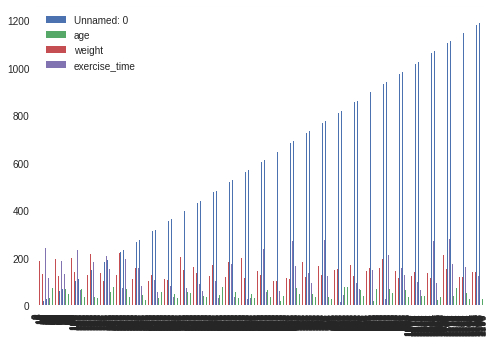

In [44]:
df_data.plot.bar();

In [54]:
# need help to understand this!!!

pd.crosstab(age_bins, [df_data['exercise_time'], df_data['weight']],
            rownames=['age bins'], colnames=['exercise_time', 'weight'],
            normalize='columns')

exercise_time   0                                                ...   300  \
weight          100  101  102  103  104  105  106  107  108  109 ...   234   
age bins                                                         ...         
(17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
(30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
(42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
(55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
(67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

exercise_time                                                
weight          236  237  238  239  240  241  242  244  246  
age bins                                                     
(17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
(30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
(42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
(55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
(67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 42042 columns]

In [63]:
# splitting into multiple dataframes

series = pd.cut(df_data['exercise_time'], 5)
df_data['bin'] = series

for b in df_data.bin.unique():
  print(df_data[df_data.bin == b].head())
  
# most helpful to understand

    Unnamed: 0  age  weight  exercise_time             bin
0            0   44     118            192  (180.0, 240.0]
2            2   46     128            220  (180.0, 240.0]
4            4   28     116            182  (180.0, 240.0]
10          10   21     160            228  (180.0, 240.0]
15          15   36     131            194  (180.0, 240.0]
    Unnamed: 0  age  weight  exercise_time           bin
1            1   41     161             35  (-0.3, 60.0]
3            3   39     216             57  (-0.3, 60.0]
7            7   21     188             37  (-0.3, 60.0]
12          12   73     209             44  (-0.3, 60.0]
13          13   27     165             48  (-0.3, 60.0]
    Unnamed: 0  age  weight  exercise_time             bin
5            5   58     103            165  (120.0, 180.0]
14          14   21     169            171  (120.0, 180.0]
17          17   69     172            147  (120.0, 180.0]
33          33   70     169            172  (120.0, 180.0]
34       

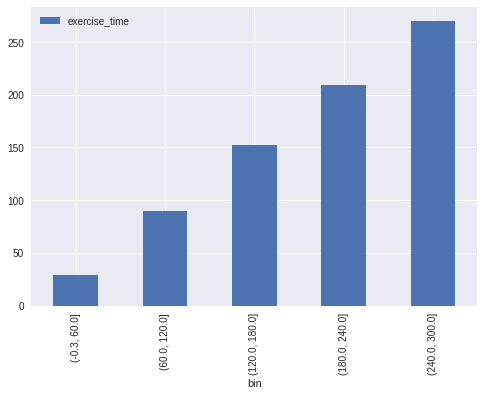

In [64]:
pd.pivot_table(
    df_data, values='exercise_time', index='bin').plot.bar();

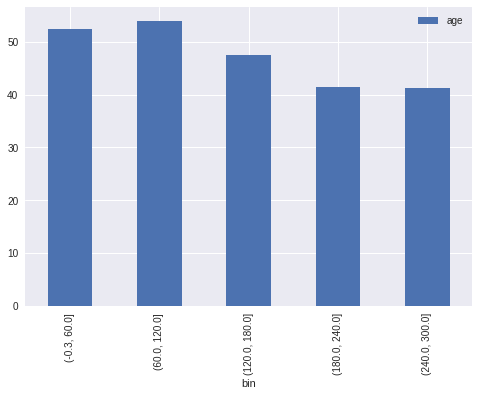

In [67]:
pd.pivot_table(df_data,values='age',
               index='bin').plot.bar()

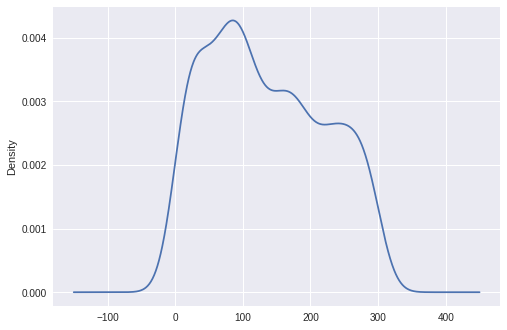

In [69]:
df_data['exercise_time'].plot.density()

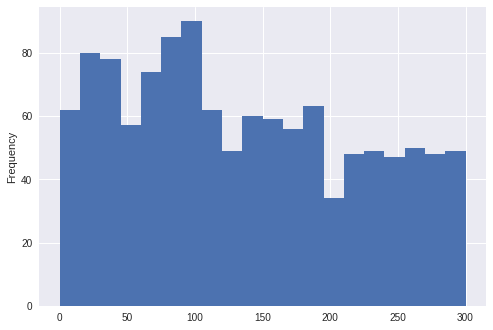

In [70]:
df_data['exercise_time'].plot.hist(bins=20)

In [77]:
#ct = pd.crosstab(age_bins, [df_data['weight'], df_data['exercise_time']],
                 #normalize='index')

ct = pd.crosstab([df_data['exercise_time'], age_bins], df_data['weight'], normalize = 'index')
ct

#need to figure this out

weight                        100  101  102  103  104  105  106  107  108  \
exercise_time age                                                           
0             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5             (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
294           (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
296           (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
297           (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (67.6, 80.0]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
298           (17.938, 30.4]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (30.4, 42.8]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
              (42.8, 55.2]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              (55.2, 67.6]    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

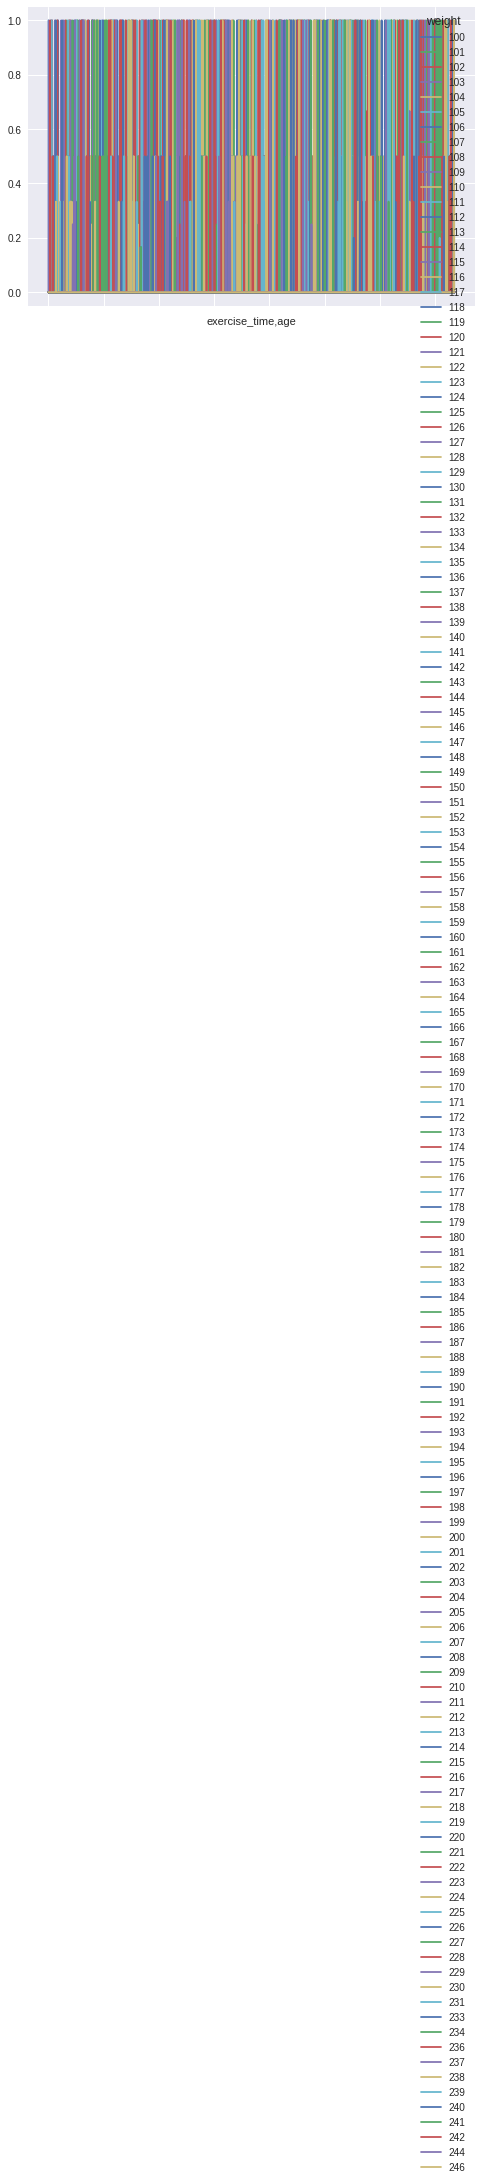

In [78]:
ct.plot()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
Ans: Age, weight and exercise time are integers and discreet in nature.

2.  What are the relationships between the variables?
Ans: Exercise time is negatively corelated with age and weight. Age and weight are positively corelated.

3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)